## Housing project_Classification
 

## 1. Preprocessing Pipeline

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier


path = r"C:\Users\Aida\OneDrive\Documents\Bootcamp_WBS\Primer\Python\WBS_DATA\8_SUP_ML\Data\housing_iteration_5_classification.csv"
data = pd.read_csv(path)

data = data.set_index('Id')
data 

# X: All columns except 'Expensive' (features)
X = data.drop(columns=['Expensive'])

# y: The 'Expensive' column (target)
y = data['Expensive']

# data splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)


In [8]:

# 0. Set the config so that we can view our preprocessor, and to transform output from numpy arrays to pandas dataframes
set_config(display="diagram")
set_config(transform_output="pandas")

# 1. defining categorical & numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(fill_value=None))

# 3. categorical pipeline

# Step 1: Defining ordinal & onehot columns
ordinal_cols = [
    'Street', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'KitchenQual', 'FireplaceQu', 
    'Functional', 'PoolQC', 'HeatingQC', 'Alley', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'Fence', 'SaleCondition'
]

onehot_cols = [
    'MSZoning', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'LotShape', 'LandContour', 
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'BsmtFinType1', 'BsmtFinType2'
]

# Step 2: Defining the categorical encoder (with "N_A" for missing values)
ordinal_categories = [ 
    ['N_A', 'Grvl', 'Pave'],  # Street
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # ExterQual
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # ExterCond
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # BsmtQual
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # BsmtCond
    ['N_A', 'Gd', 'Av', 'Mn', 'No'],  # BsmtExposure
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # KitchenQual
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # FireplaceQu
    ['N_A', 'Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],  # Functional
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # PoolQC
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # HeatingQC
    ['N_A', 'Grvl', 'Pave'],  # Alley
    ['N_A', 'Fin', 'RFn', 'Unf'],  # GarageFinish
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # GarageQual
    ['N_A', 'Ex', 'Gd', 'TA', 'Fa', 'Po'],  # GarageCond
    ['N_A', 'Y', 'P', 'N'],  # PavedDrive
    ['N_A', 'GdPrv', 'MnPrv', 'GdWo', 'MnWw'],  # Fence
    ['N_A', 'Normal', 'Abnorml', 'AdjLand', 'Alloca', 'Family', 'Partial']  # SaleCondition
]


# Define the categorical encoder for ordinal and one-hot encoding
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_cols)
    ]
)

# Step 3: Categorical pipeline: "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),  # Impute missing values with 'N_A' in categorical columns
    categorical_encoder
)

# 4. full preprocessing: a ColumnTransformer with 2 branches: numeric & categorical
full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categorical_pipe, X_cat.columns),
    ]
)




## 2. Modelling (Random Forest)

In [36]:
# Build the Random Forest pipeline
full_pipeline_rf = make_pipeline(full_preprocessing,
                                 RandomForestClassifier(random_state=42))  # Random seed for reproducibility

# Define the parameter grid for Random Forest
param_grid_rf = {
    # Hyperparameters for the numerical pipeline
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median", "constant"],  # Imputation strategy for numerical data
    "columntransformer__num_pipe__simpleimputer__fill_value": [10, 0, -1],  # Test different fill values for constant imputation

    # Hyperparameters for the Random Forest model
    "randomforestclassifier__n_estimators": [50, 100],  # Number of trees in the forest
    "randomforestclassifier__max_depth": [None, 10, 20, 40],  # Maximum depth of trees
    "randomforestclassifier__min_samples_split": [2, 5, 6],  # Minimum number of samples to split an internal node
    "randomforestclassifier__min_samples_leaf": [1, 2, 2],  # Minimum number of samples required at each leaf node
    "randomforestclassifier__bootstrap": [True, False],  # Whether bootstrap samples are used
}

# Perform GridSearchCV for hyperparameter tuning
search_rf = GridSearchCV(full_pipeline_rf,
                         param_grid_rf,
                         cv=5,
                         verbose=1,
                         n_jobs=-1)

# Fit the model
search_rf.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best Parameters:", search_rf.best_params_)
print("Best Score:", search_rf.best_score_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters: {'columntransformer__num_pipe__simpleimputer__fill_value': 0, 'columntransformer__num_pipe__simpleimputer__strategy': 'constant', 'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 50}
Best Score: 0.9554858589193354


## 3. Error analysis

In [37]:
# Make predictions on the training data
y_train_pred = search_rf.predict(X_train)

# Calculate accuracy score
accuracy = accuracy_score(y_train, y_train_pred)

print(f"Accuracy on training data: {accuracy:.4f}")

Accuracy on training data: 0.9983


In [38]:
# Make predictions on the test data
y_test_pred = search_rf.predict(X_test)

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy on test data: {test_accuracy:.4f}")


Accuracy on test data: 0.9521


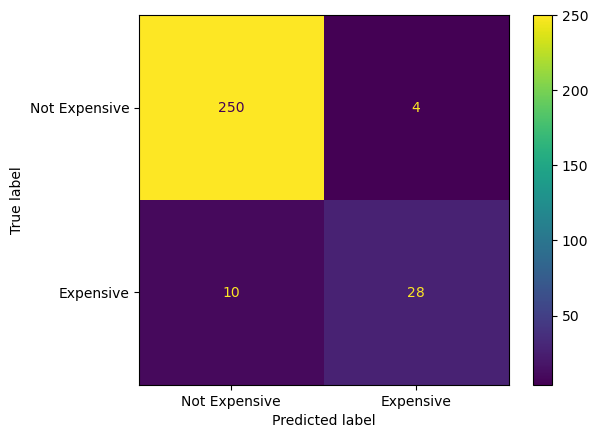

In [39]:
# plot_confusion_matrix(search, X_test, y_test, display_labels=['Not Expensive', 'Expensive']);

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search_rf,
                                      X_test,
                                      y_test,
                                      display_labels=['Not Expensive', 'Expensive']);

In [40]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config
set_config(transform_output="pandas")


url = "https://drive.google.com/file/d/15PfmTxmavQCT-f7iY9tgwWxm9t4GRees/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
testing_data = pd.read_csv(path)
testing_data = testing_data.set_index('Id')

In [41]:
full_pipeline_rf.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1'...
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [42]:
full_pipeline_rf.predict(testing_data)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
testing_data['Expensive'] =full_pipeline_rf.predict(testing_data)

In [44]:
# Export the column 'Expensive' along with the index to create a submission file
testing_data['Expensive'].to_csv('./submission.csv')

In [45]:
import shutil

# Move or copy the file to a desired location on your machine
shutil.copy('./submission.csv', r'C:\Users\Aida\OneDrive\Documents\Bootcamp_WBS\Primer\Python\WBS_DATA\8_SUP_ML\Data\submissionRF03.csv')


'C:\\Users\\Aida\\OneDrive\\Documents\\Bootcamp_WBS\\Primer\\Python\\WBS_DATA\\8_SUP_ML\\Data\\submissionRF03.csv'